In [1]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
import subprocess
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
xr.open_dataset('/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/SSS/SMAP/SMAP_L3_SSS_20190509_8DAYS_V5.0.nc')

<xarray.Dataset>
Dimensions:               (latitude: 720, longitude: 1440, time: 1)
Coordinates:
  * latitude              (latitude) float32 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude             (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * time                  (time) datetime64[ns] 2019-05-09T12:00:00
Data variables:
    smap_sss              (latitude, longitude) float32 ...
    anc_sss               (latitude, longitude) float32 ...
    anc_sst               (latitude, longitude) float32 ...
    smap_spd              (latitude, longitude) float32 ...
    smap_high_spd         (latitude, longitude) float32 ...
    weight                (latitude, longitude) float32 ...
    land_fraction         (latitude, longitude) float32 ...
    ice_fraction          (latitude, longitude) float32 ...
    smap_sss_uncertainty  (latitude, longitude) float32 ...
Attributes: (12/40)
    title:                       SMAP 0.25x0.25 deg grid averaged 8-day SSS/WSPD
    institution:                 Jet Propulsion Laboratory
    source:                      SMAP L2B SSS
    history:                     DATA_SOURCE_VERSION V5.0 L2B SMAP SSS/WSPD
    comment:                     Gaussian-weighted map gridding of SMAP L2B S...
    Gaussian_window_radius:      45.0
    ...                          ...
    creator_name:                JPL
    creator_email:               fore@jpl.nasa.gov
    publisher_name:              Alexander G. Fore
    publisher_email:             fore@jpl.nasa.gov
    contributor_name:            Alexander Fore, Simon Yueh, Wenqing Tang, Ak...
    references:                  10.1109/TGRS.2016.2601486, 10.1109/TGRS.2016...

# Directory set-up

In [3]:
rep = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/1D_OJH/1D_ocean_ice_column/Global_RUN/"
state = "/mnc_test_0002/state.0000000000.t001.nc"
sice = "/mnc_test_0002/sice.0000000000.t001.nc"
exf_avg = "/mnc_test_0002/EXF_avg_daily.0000000000.t001.nc"
exf_net_avg = "/mnc_test_0002/EXF_net_avg_daily.0000000000.t001.nc"
ICE_avg_daily_qnet = "/mnc_test_0002/ICE_avg_daily_qnet.0000000000.t001.nc"
obsIceFrac = "/IceFrac_four_months.bin"

In [4]:
# profile selection
irun = 0
profID = "run_"+str(irun+1).zfill(3)
profID

'run_001'

In [5]:
# model output
# T, S, Z and time from the model output
dstate = xr.open_dataset(rep+profID+state)
dstate.T.size

145

In [6]:
Time_size = np.ones(250)
for irun in np.arange(Time_size.size):
    profID = "run_"+str(irun+1).zfill(3)
    ds = xr.open_dataset(rep+profID+state).T
    Time_size[irun] = ds.size
    #print(np.array(ds[-1]))
    z = xr.open_dataset(rep+profID+state).Z
Time_ref = xr.open_dataset(rep+"run_"+str(1).zfill(3)+state).T

In [7]:
print(min(Time_size),max(Time_size))

135.0 145.0


In [8]:
np.array(Time_ref)[0]

numpy.datetime64('2022-09-09T00:00:00.000000000')

# New Variables to use

In [9]:
Time_size_max = int(max(Time_size))
profile  = np.arange(1,251,1)
Temp_new = np.ndarray(shape = (profile.size,70,Time_size_max), dtype = float)*np.nan
S_new    = np.ndarray(shape = (profile.size,70,Time_size_max), dtype = float)*np.nan
Eta_new  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan

# Grouping for S, T and Eta

In [10]:
for irun in np.arange(profile.size):
    profID = "run_"+str(irun+1).zfill(3)
    ds = xr.open_dataset(rep+profID+state)
    Temp = np.squeeze(ds.Temp.T)
    S = np.squeeze(ds.S.T)
    Eta = np.squeeze(ds.Eta)
    TimeSize = ds.T.size
    T_start_index = Time_size_max - TimeSize
    if T_start_index == 0:
        Temp_new[irun,:,:] = Temp
        S_new[irun,:,:] = S
        Eta_new[irun,:] = Eta
    else:
        Tindex = np.arange(T_start_index,Time_size_max,1)
        Temp_new[irun,:,Tindex] = Temp.T
        S_new[irun,:,Tindex] = S.T
        Eta_new[irun,Tindex] = Eta        

In [11]:
Temp_new2 = np.where(Temp_new!=0,Temp_new,np.nan)
S_new2 = np.where(S_new!=0,S_new,np.nan)

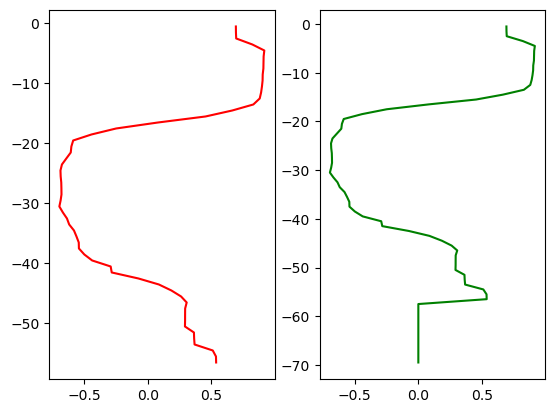

In [12]:
# verifica
plt.subplot(121)
plt.plot(Temp_new2[-1,:,12],z,'r')
plt.subplot(122)
plt.plot(Temp[:,2],z,'g')

# Grouping for Exf and Sl diagnostic heat flux terms
- Sea Ice variables

In [13]:
Ice_thickness = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Ice_coverage  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Ice_EmPmR     = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Ice_Qnet      = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Ice_Qsw       = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan

In [14]:
for irun in np.arange(profile.size):
    profID = "run_"+str(irun+1).zfill(3)
    ds = xr.open_dataset(rep+profID+sice)
    Thikness = np.squeeze(ds.si_HEFF)
    Coverage = np.squeeze(ds.si_AREA)
    EmPmR = np.squeeze(ds.EmPmR)
    Qnet = np.squeeze(ds.Qnet)
    Qsw = np.squeeze(ds.Qsw)
    TimeSize = ds.T.size
    T_start_index = Time_size_max - TimeSize
    if T_start_index == 0:
        Ice_thickness[irun,:] = Thikness
        Ice_coverage[irun,:]  = Coverage
        Ice_EmPmR[irun,:]     = EmPmR
        Ice_Qnet[irun,:]      = Qnet
        Ice_Qsw[irun,:]       = Qsw
    else:
        Tindex = np.arange(T_start_index,Time_size_max,1)
        Ice_thickness[irun,Tindex] = Thikness
        Ice_coverage[irun,Tindex]  = Coverage
        Ice_EmPmR[irun,Tindex]     = EmPmR
        Ice_Qnet[irun,Tindex]      = Qnet
        Ice_Qsw[irun,Tindex]       = Qsw

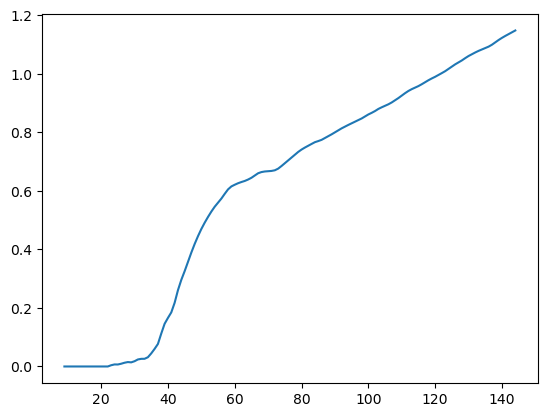

In [15]:
## verification
zata = plt.plot(Ice_thickness[235,:])

- Exf heat flux terms

In [16]:
Exf_EXFhs     = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFhl     = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFempmr  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFpreci  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFevap   = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFaqh    = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFatemp  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFswdn   = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan 
Exf_EXFlwdn   = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFvwind  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFuwind  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan

In [17]:
for irun in np.arange(profile.size):
    profID = "run_"+str(irun+1).zfill(3)
    ds = xr.open_dataset(rep+profID+exf_avg)
    EXFhs = np.squeeze(ds.EXFhs)
    EXFhl = np.squeeze(ds.EXFhl)
    EXFempmr = np.squeeze(ds.EXFempmr)
    EXFpreci = np.squeeze(ds.EXFpreci)
    EXFevap = np.squeeze(ds.EXFevap)
    EXFaqh = np.squeeze(ds.EXFaqh)
    EXFatemp = np.squeeze(ds.EXFatemp)
    EXFswdn = np.squeeze(ds.EXFswdn)
    EXFlwdn = np.squeeze(ds.EXFlwdn)
    EXFvwind = np.squeeze(ds.EXFvwind)
    EXFuwind = np.squeeze(ds.EXFuwind)
    TimeSize = ds.T.size
    T_start_index = Time_size_max - TimeSize
    if T_start_index == 0:
        Exf_EXFhs[irun,:]     = EXFhs
        Exf_EXFhl[irun,:]     = EXFhl
        Exf_EXFempmr[irun,:]  = EXFempmr
        Exf_EXFpreci[irun,:]  = EXFpreci
        Exf_EXFevap[irun,:]   = EXFevap
        Exf_EXFaqh[irun,:]    = EXFaqh
        Exf_EXFatemp[irun,:]  = EXFatemp
        Exf_EXFswdn[irun,:]   = EXFswdn
        Exf_EXFlwdn[irun,:]   = EXFlwdn
        Exf_EXFvwind[irun,:]  = EXFvwind
        Exf_EXFuwind[irun,:]  = EXFuwind
    else:
        Tindex = np.arange(T_start_index,Time_size_max,1)
        Exf_EXFhs[irun,Tindex]     = EXFhs
        Exf_EXFhl[irun,Tindex]     = EXFhl
        Exf_EXFempmr[irun,Tindex]  = EXFempmr
        Exf_EXFpreci[irun,Tindex]  = EXFpreci
        Exf_EXFevap[irun,Tindex]   = EXFevap
        Exf_EXFaqh[irun,Tindex]    = EXFaqh
        Exf_EXFatemp[irun,Tindex]  = EXFatemp
        Exf_EXFswdn[irun,Tindex]   = EXFswdn
        Exf_EXFlwdn[irun,Tindex]   = EXFlwdn
        Exf_EXFvwind[irun,Tindex]  = EXFvwind
        Exf_EXFuwind[irun,Tindex]  = EXFuwind

- Exf heat flux terms (net)

In [18]:
Exf_EXFqnet   = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFswnet  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
Exf_EXFlwnet  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan

In [19]:
for irun in np.arange(profile.size):
    profID = "run_"+str(irun+1).zfill(3)
    ds = xr.open_dataset(rep+profID+exf_net_avg)
    EXFqnet = np.squeeze(ds.EXFqnet)
    EXFswnet = np.squeeze(ds.EXFswnet)
    EXFlwnet = np.squeeze(ds.EXFlwnet)
    TimeSize = ds.T.size
    T_start_index = Time_size_max - TimeSize
    if T_start_index == 0:
        Exf_EXFqnet[irun,:]   = EXFqnet
        Exf_EXFswnet[irun,:]  = EXFswnet
        Exf_EXFlwnet[irun,:]  = EXFlwnet
    else:
        Tindex = np.arange(T_start_index,Time_size_max,1)
        Exf_EXFqnet[irun,Tindex]   = EXFqnet
        Exf_EXFswnet[irun,Tindex]  = EXFswnet
        Exf_EXFlwnet[irun,Tindex]  = EXFlwnet

In [20]:
EXFqnet

<xarray.DataArray 'EXFqnet' (T: 134)>
array([ 11.205555,   4.387197,  22.013191,  53.738506,  87.84202 ,  78.234146,
        55.062157,  72.35472 , 109.770515, 106.23912 ,  63.00242 ,  80.826225,
       101.724724,  58.80788 ,  52.03343 ,  26.851114,  14.211469,  20.036072,
        31.04696 ,  41.522995,  51.575104,  43.155857,  38.356888,  63.810333,
        93.82622 ,  90.46077 ,  84.96259 , 193.29034 , 215.88184 , 139.49976 ,
       131.81505 , 230.46593 , 333.38593 , 305.78998 , 286.72293 , 333.76385 ,
       400.4336  , 446.99695 , 449.16605 , 463.79987 , 477.05768 , 456.1082  ,
       405.90637 , 414.93063 , 428.02466 , 433.8818  , 378.15503 , 310.41418 ,
       220.08688 , 180.94463 , 198.50069 , 137.36482 , 105.74467 , 132.02339 ,
       142.1343  , 173.74454 , 220.59232 , 167.75566 , 102.08992 ,  68.47882 ,
        57.64954 ,  99.19657 , 181.66385 , 368.59802 , 401.0561  , 427.24408 ,
       452.2742  , 405.01218 , 331.49567 , 374.4184  , 293.76996 , 185.76877 ,
       200.2826  , 196.24591 , 170.85431 , 194.89438 , 534.3305  , 722.27374 ,
       598.43396 , 555.204   , 428.04962 , 290.42938 , 291.40442 , 520.63446 ,
       474.58597 , 230.5605  , 295.5129  , 370.6311  , 421.38074 , 315.7087  ,
       246.12985 , 314.94263 , 413.95944 , 303.5099  , 199.58224 , 292.19473 ,
       407.67624 , 451.38855 , 451.89966 , 609.8531  , 686.6348  , 654.1354  ,
       535.9167  , 450.37527 , 590.8254  , 760.96594 , 663.6086  , 616.2741  ,
       570.71075 , 473.76834 , 498.47968 , 513.8576  , 516.4248  , 620.5626  ,
       730.5698  , 744.7121  , 647.83716 , 578.336   , 613.9862  , 649.35815 ,
       684.0635  , 660.4186  , 504.55115 , 352.05637 , 343.68723 , 461.14923 ,
       612.04004 , 683.5274  , 624.53625 , 484.7354  , 439.24234 , 482.92047 ,
       483.181   , 542.274   ], dtype=float32)
Coordinates:
  * T        (T) datetime64[ns] 2022-09-20 2022-09-21 ... 2023-01-30 2023-01-31
    X        float64 2.5e+03
    Y        float64 2.5e+03
Attributes:
    description:  Net upward heat flux (turb+rad), >0 decreases theta
    units:        W/m^2

- ICE average daily Qnet

In [21]:
SIqnet   = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
SIqsw    = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
SIqneto  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan
SIqneti  = np.ndarray(shape = (profile.size,Time_size_max), dtype = float)*np.nan

In [22]:
xr.open_dataset(rep+"run_"+str(1).zfill(3)+ICE_avg_daily_qnet)

<xarray.Dataset>
Dimensions:      (T: 144, Zmd000001: 1, X: 1, Y: 1, Zd000001: 1)
Coordinates:
  * T            (T) datetime64[ns] 2022-09-10 2022-09-11 ... 2023-01-31
  * X            (X) float64 2.5e+03
  * Y            (Y) float64 2.5e+03
Dimensions without coordinates: Zmd000001, Zd000001
Data variables:
    iter         (T) int32 ...
    diag_levels  (Zmd000001) float64 ...
    SIqnet       (T, Zd000001, Y, X) float32 ...
    SIqsw        (T, Zd000001, Y, X) float32 ...
    SIqneto      (T, Zd000001, Y, X) float32 ...
    SIqneti      (T, Zd000001, Y, X) float32 ...
Attributes: (12/20)
    MITgcm_version:  checkpoint66g
    build_host:      389c2bb8382c
    build_date:      Fri Nov 10 00:33:14 UTC 2023
    MITgcm_URL:      http://mitgcm.org
    MITgcm_tag_id:   1.2326 2017/04/24
    MITgcm_mnc_ver:  0.9
    ...              ...
    nSy:             1
    nPx:             1
    nPy:             1
    Nx:              1
    Ny:              1
    Nr:              70

In [23]:
for irun in np.arange(profile.size):
    profID = "run_"+str(irun+1).zfill(3)
    ds = xr.open_dataset(rep+profID+ICE_avg_daily_qnet)
    siqnet   = np.squeeze(ds.SIqnet)
    siqsw    = np.squeeze(ds.SIqsw)
    siqneto  = np.squeeze(ds.SIqneto)
    siqneti  = np.squeeze(ds.SIqneti)
    TimeSize = ds.T.size
    T_start_index = Time_size_max - TimeSize
    if T_start_index == 0:
        SIqnet[irun,:]   = siqnet
        SIqsw[irun,:]    = siqsw
        SIqneto[irun,:]  = siqneto
        SIqneti[irun,:]  = siqneti
    else:
        Tindex = np.arange(T_start_index,Time_size_max,1)
        SIqnet[irun,Tindex]   = siqnet
        SIqsw[irun,Tindex]    = siqsw
        SIqneto[irun,Tindex]  = siqneto
        SIqneti[irun,Tindex]  = siqneti

In [24]:
siqneti.shape

(134,)

In [25]:
#ds = xr.open_dataset(rep+profID+state)
#ds = xr.open_dataset(rep+profID+sice)
#ds = xr.open_dataset(rep+profID+exf_net_avg)
#ds = xr.open_dataset(rep+profID+exf_avg)
#ds

# Get the "lon" and "lat" of castawys CTD

In [26]:
#-------------------------------------------------------------------------------------------------------|
## SASSIE final data collected files directory ---------------------------------------------------------|
Final_SASSIE    = '/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/Final_SASSIE_update/'#------------|
## Data files directory --------------------------------------------------------------------------------|
CastAway_CTD    = 'CastAway_CTD/'#----------------------------------------------------------------------|
#-------------------------------------------------------------------------------------------------------|
## Cast away CTD data list
CastAway_CTD_content = os.listdir(Final_SASSIE+CastAway_CTD)
#-------------------------------------------------------------------------------------------------------|
CTD_cast = xr.open_dataset(Final_SASSIE+CastAway_CTD+CastAway_CTD_content[0])
Lon = CTD_cast.longitude
Lat = CTD_cast.latitude

# Saving data in one NetCdf file

In [27]:
## Defining xr dataset for coords and variables
xrds = xr.Dataset(
    coords= dict(time = np.array(Time_ref),
                 depth = np.array(z),
                 nbr_profile = profile),
    data_vars = dict(
        Longitude      = (["nbr_profile"],Lon.data),
        Latitude       = (["nbr_profile"],Lat.data),
        Temp           = (["nbr_profile","depth","time"],Temp_new.data),
        Sal            = (["nbr_profile","depth","time"],S_new.data),
        ETA            = (["nbr_profile","time"],Eta_new.data),
        Ice_thickness  = (["nbr_profile","time"],Ice_thickness.data),
        Ice_coverage   = (["nbr_profile","time"],Ice_coverage.data),
        Ice_EmPmR      = (["nbr_profile","time"],Ice_EmPmR.data),
        Ice_Qnet       = (["nbr_profile","time"],Ice_Qnet.data),
        Ice_Qsw        = (["nbr_profile","time"],Ice_Qsw.data),
        EXFhs          = (["nbr_profile","time"],Exf_EXFhs.data),     
        EXFhl          = (["nbr_profile","time"],Exf_EXFhl.data),
        EXFempmr       = (["nbr_profile","time"],Exf_EXFempmr.data),
        EXFpreci       = (["nbr_profile","time"],Exf_EXFpreci.data),
        EXFevap        = (["nbr_profile","time"],Exf_EXFevap.data),
        EXFaqh         = (["nbr_profile","time"],Exf_EXFaqh.data),
        EXFatemp       = (["nbr_profile","time"],Exf_EXFatemp.data),
        EXFswdn        = (["nbr_profile","time"],Exf_EXFswdn.data),
        EXFlwdn        = (["nbr_profile","time"],Exf_EXFlwdn.data),
        EXFvwind       = (["nbr_profile","time"],Exf_EXFvwind.data),
        EXFuwind       = (["nbr_profile","time"],Exf_EXFuwind.data),
        EXFqnet        = (["nbr_profile","time"],Exf_EXFqnet.data),
        EXFswnet       = (["nbr_profile","time"],Exf_EXFswnet.data),
        EXFlwnet       = (["nbr_profile","time"],Exf_EXFlwnet.data),
        SIqnet         = (["nbr_profile","time"],SIqnet.data),
        SIqsw          = (["nbr_profile","time"],SIqsw.data),
        SIqneto        = (["nbr_profile","time"],SIqneto.data),
        SIqneti        = (["nbr_profile","time"],SIqneti.data)
        )
    )
## Adding vriables attrs
xrds['time'].attrs['long_name'] = 'time since 1950-01-01'
#----------------------------------------------------------------------
xrds['Longitude'].attrs = {'units': 'degree_east',
                           'long_name': 'longitude'}
#----------------------------------------------------------------------
xrds['Latitude'].attrs = {'units': 'degree_north',
                          'long_name': 'latitude'}
#----------------------------------------------------------------------
xrds['Temp'].attrs = {'units': 'degC',
                      'long_name': 'potential_temperature'
                     }
#----------------------------------------------------------------------
xrds['Sal'].attrs  = {'units': 'pss',
                    'long_name': 'salinity'
                     }
#----------------------------------------------------------------------
xrds['ETA'].attrs  = {'units': 'm',
                      'long_name': 'free-surface_r-anomaly'
                     }
#----------------------------------------------------------------------
xrds['Ice_thickness'].attrs= xr.open_dataset(rep+profID+sice).si_HEFF.attrs
#----------------------------------------------------------------------
xrds['Ice_coverage'].attrs = xr.open_dataset(rep+profID+sice).si_AREA.attrs
#----------------------------------------------------------------------
xrds['Ice_EmPmR'].attrs    = xr.open_dataset(rep+profID+sice).EmPmR.attrs
#----------------------------------------------------------------------
xrds['Ice_Qnet'].attrs     = xr.open_dataset(rep+profID+sice).Qnet.attrs
#----------------------------------------------------------------------
xrds['Ice_Qsw'].attrs      = xr.open_dataset(rep+profID+sice).Qsw.attrs
#----------------------------------------------------------------------
xrds['EXFhs'].attrs        = xr.open_dataset(rep+profID+exf_avg).EXFhs.attrs   
xrds['EXFhl'].attrs        = xr.open_dataset(rep+profID+exf_avg).EXFhl.attrs
xrds['EXFempmr'].attrs     = xr.open_dataset(rep+profID+exf_avg).EXFempmr.attrs
xrds['EXFpreci'].attrs     = xr.open_dataset(rep+profID+exf_avg).EXFpreci.attrs
xrds['EXFevap'].attrs      = xr.open_dataset(rep+profID+exf_avg).EXFevap.attrs
xrds['EXFaqh'].attrs       = xr.open_dataset(rep+profID+exf_avg).EXFaqh.attrs
xrds['EXFatemp'].attrs     = xr.open_dataset(rep+profID+exf_avg).EXFatemp.attrs
xrds['EXFswdn'].attrs      = xr.open_dataset(rep+profID+exf_avg).EXFswdn.attrs
xrds['EXFlwdn'].attrs      = xr.open_dataset(rep+profID+exf_avg).EXFlwdn.attrs
xrds['EXFvwind'].attrs     = xr.open_dataset(rep+profID+exf_avg).EXFvwind.attrs
xrds['EXFuwind'].attrs     = xr.open_dataset(rep+profID+exf_avg).EXFuwind.attrs
#----------------------------------------------------------------------
xrds['EXFqnet'].attrs      = xr.open_dataset(rep+profID+exf_net_avg).EXFqnet.attrs
xrds['EXFswnet'].attrs     = xr.open_dataset(rep+profID+exf_net_avg).EXFswnet.attrs
xrds['EXFlwnet'].attrs     = xr.open_dataset(rep+profID+exf_net_avg).EXFlwnet.attrs
#----------------------------------------------------------------------
xrds['SIqnet'].attrs      = xr.open_dataset(rep+profID+ICE_avg_daily_qnet).SIqnet.attrs
xrds['SIqsw'].attrs       = xr.open_dataset(rep+profID+ICE_avg_daily_qnet).SIqsw.attrs
xrds['SIqneto'].attrs     = xr.open_dataset(rep+profID+ICE_avg_daily_qnet).SIqneto.attrs
xrds['SIqneti'].attrs     = xr.open_dataset(rep+profID+ICE_avg_daily_qnet).SIqneti.attrs
## adding global attrs
xrds.attrs = dict(
    Ocean_forcing_data ='Castaway CTD from SASSIE cruise of Fall 2022',
    Atmospheric_forcing_data = 'Atmospheric data from GES DISC PLATFORM',
    MITgcn = '1D ocean Ice Column model output simulated with SASSIE castaway CTD measurements',
    Creation_date_of_file =datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"),
    Author_of_file = 'Odilon Joel Houndegnonto, Severine Fournier and Ian Fenty')
#--- Save the data in ".nc" file:=>  to_netcdf('filename.nc',encoding=my_encoding)
xrds.to_netcdf(rep+"One_1DMITgcm_output_Full.nc",'w')

In [ ]:
iprof = 2
plt.plot(Time_ref,np.squeeze(Ice_thickness[iprof,:]),label='Model effective ice thickness [m]',linewidth=3.5)

In [ ]:
np.array(xr.open_dataset(rep+profID+exf_net_avg).EXFqnet).shape

# Figures

In [ ]:
iprof = 1
# Observation Ice concentration from GES-DISC
IceFrac = np.fromfile(rep+"run_"+str(1).zfill(3)+obsIceFrac, '>f4')
# forcing starting date
t0_forcing = np.datetime64('2022-09-01','ns')
# model starting date
t0_model = Time_ref[0]
# time stating index for obs data to match model outpu
obs_start_ind = int((t0_model - t0_forcing)/(1000000000*3600*24))
# model ice formation date with 15% criteria
# form the model
a = odi.odi_sea_ice_day(ice_conc=Ice_coverage[iprof,:],ice_stick=0.15,days_stick=5)
# form the observation
b = odi.odi_sea_ice_day(ice_conc=IceFrac[obs_start_ind:],ice_stick=0.15,days_stick=5)
print("model ice date index",a,"\n obs ice date index",b)
#-----------------------------------------------------------------------------------------------#
fig = plt.figure(figsize=[27,60], num=1);plt.clf();
fig.subplots_adjust(hspace=0.5)
plt.subplot(6,1,1)
plt.plot(Time_ref,np.squeeze(Ice_thickness[iprof,:]),label='Model effective ice thickness [m]',linewidth=3.5)
#plt.plot(t[ti],IceFrac[ti],label='Observed Ice covered fraction')
plt.xticks(Time_ref[np.arange(0,Time_ref.size,5)],rotation=65,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('[m]',fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.ylim(-.1,1.25)
plt.title("T&S-CTD profiles on "+str(np.array(Time_ref[0]))[slice(0,10,1)],fontsize=25)
#-----------------------------------------------------------------------------------------------#
plt.subplot(6,1,2)
plt.plot(Time_ref,np.squeeze(Ice_coverage[iprof,:]),label='Model ice coerage fraction',linewidth=5)
plt.plot(Time_ref,IceFrac[obs_start_ind:],label='Observed Ice covered fraction',linewidth=2.5)
## Model ice formation date
plt.plot(Time_ref[a],Ice_coverage[iprof,:][a],'or',markersize=10,label='Model ice formation date')
## observed ice formation date
plt.plot(Time_ref[b],IceFrac[obs_start_ind:][b],'og',markersize=10,label='Observed ice formation date')
plt.xticks(Time_ref[np.arange(0,Time_ref.size,5)],rotation=65,fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.1,1.1)
plt.grid()
plt.ylabel('[1]',fontsize=20)
plt.legend(fontsize=20)
#-----------------------------------------------------------------------------------------------#
plt.subplot(6,1,3)
plt.plot(Time_ref,Exf_EXFhs[iprof,:],label="EXFhs")
plt.xticks(Time_ref[np.arange(0,Time_ref.size,5)],rotation=65,fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.subplot(6,1,4)
plt.plot(Time_ref,Exf_EXFhl[iprof,:],label="EXFhl")
plt.xticks(Time_ref[np.arange(0,Time_ref.size,5)],rotation=65,fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.subplot(6,1,5)
plt.plot(Time_ref,Exf_EXFempmr[iprof,:],label="EXFempmr")
plt.xticks(Time_ref[np.arange(0,Time_ref.size,5)],rotation=65,fontsize=15)
plt.legend(fontsize=20)
plt.grid()

In [ ]:
fig = plt.figure(figsize=[15,4], num=1);plt.clf();
fig.subplots_adjust(hspace=0.5)
plt.subplot(1,1,1)
plt.plot(Time_ref,np.squeeze(Exf_EXFqnet[iprof,:]),label='EXFqnet',linewidth=3.5)
#plt.plot(t[ti],IceFrac[ti],label='Observed Ice covered fraction')
#plt.xticks(Time_ref[np.arange(0,Time_ref.size,5)],rotation=65,fontsize=15)
plt.yticks(fontsize=15)
#plt.ylabel('[m]',fontsize=20)
plt.legend(fontsize=20)
plt.grid()
#plt.ylim(-.1,1.25)
plt.title("T&S-CTD profiles on "+str(np.array(Time_ref[0]))[slice(0,10,1)],fontsize=25)
#------------------------------------------